In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium.plugins import HeatMap

from data_preparation import data_acquisition
from data_preparation import data_conditioning

# Prepare data

In [ ]:
prep = data_acquisition(working_dir='data', plot=False)
prep.fetch_data(years=[2015,2016,2017,2018,2019,2020,2021,2022])
prep.save_data()

# Data inspection

<AxesSubplot:xlabel='date'>

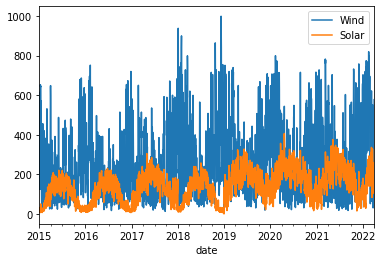

In [2]:
weather_electricity = pd.read_csv('../data/weather_electricity_data.csv', infer_datetime_format=True)
weather_electricity['date'] = pd.to_datetime(weather_electricity['date'])
weather_electricity.set_index(['date'], inplace=True)

weather_electricity.plot(y=['Wind', 'Solar'])

# ML with XGBoost, learn the solar data

## Establish a baseline model

In [10]:
allsky_columns = [col for col in weather_electricity.columns if 'ALLSKY_SFC_SW_DWN' in col]

# Select subset of predictors and the target
X = weather_electricity[allsky_columns].copy()
y = weather_electricity.Solar

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, train_size=0.9)

solar_regressor = xgb.XGBRegressor(n_estimators=500, early_stopping_rounds=5, learning_rate=0.1)
solar_regressor.fit(X_train, y_train, 
                    eval_set=[(X_test, y_test)],
                    verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=5, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [12]:
# Predict using the model
y_predicted = solar_regressor.predict(X_test)

# RMSE Computation
rmse = np.sqrt(MSE(y_test, y_predicted))
print("RMSE : % .2f" %(rmse))
print("Average of y : % .2f" %(y.mean()))

RMSE :  70.94
Average of y :  140.26


## With stationary data

In [14]:
data = data_conditioning(X_train, X_test, y_train, y_test)
y_train_stationary, y_test_stationary = data.y_train_stationary, data.y_test_stationary

solar_stationary_regressor = xgb.XGBRegressor(n_estimators=500, early_stopping_rounds=5, learning_rate=0.1)
solar_stationary_regressor.fit(X_train, y_train_stationary, 
                               eval_set=[(X_test, y_test_stationary)],
                               verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=5, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [23]:
# Predict using the model
y_stationary_predicted = solar_stationary_regressor.predict(X_test)
y_predicted = data.reverse_stationary(y_stationary_predicted)

# RMSE Computation
rmse = np.sqrt(MSE(y_test, y_predicted))
print("RMSE : % .2f" %(rmse))
print("Average of y : % .2f" %(pd.concat([y_train_stationary, y_test_stationary]).mean()))

RMSE :  48.55
Average of y :  73.82


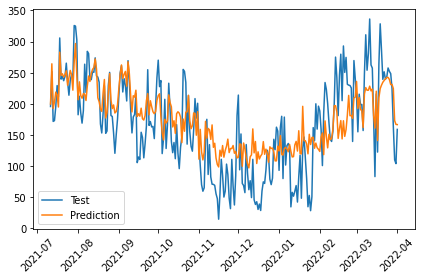

In [29]:
plt.figure()

plt.plot(y_test, label='Test')
plt.plot(X_test.index, y_predicted, label='Prediction')

plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()

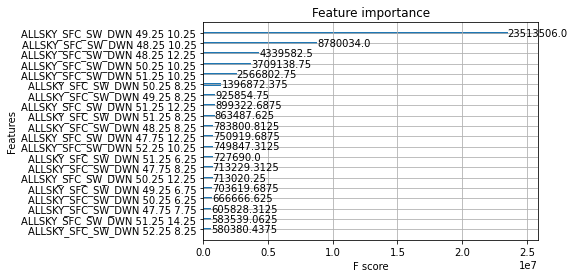

<Figure size 1152x864 with 0 Axes>

In [30]:
ax = xgb.plot_importance(solar_stationary_regressor, max_num_features=20, importance_type='total_gain')
#ax.set_xscale('log')
plt.figure(figsize = (16, 12))
plt.show()

ALLSKY_SFC_DWN seems to be the most important feature

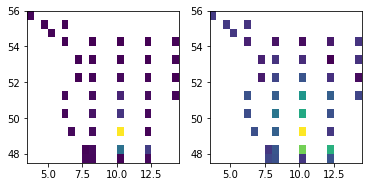

In [32]:
# get feature impotance from regressor
feature_importance = solar_regressor.get_booster().get_score(importance_type='total_gain')

# make a data frame with feature importances
feature_importance = pd.DataFrame.from_dict(feature_importance, orient='index', columns=["total_gain"]).sort_values(by = "total_gain", ascending=False)

# make a subset containing only "allsky..." feature importances
feature_importance_allsky = [row for row in feature_importance.index if 'ALLSKY_SFC_SW_DWN' in row]
feature_importance_allsky = feature_importance.loc[feature_importance.index.intersection(feature_importance_allsky)]

# put latitude, longitude and importance into a dataframe
feature_importance_allsky_map = [[row[0].split()[1], row[0].split()[2], row[1]['total_gain']] for row in feature_importance_allsky.iterrows()]
feature_importance_allsky_map = pd.DataFrame(feature_importance_allsky_map, columns = ['LAT', 'LON', 'importance'], dtype=float)


res = 0.5
LAT_map, LON_map = np.meshgrid(np.arange(feature_importance_allsky_map.LAT.min(), feature_importance_allsky_map.LAT.max()+res, res),
                               np.arange(feature_importance_allsky_map.LON.min(), feature_importance_allsky_map.LON.max()+res, res))

IMP_map = np.zeros(len(LAT_map.ravel()))

for i, (LAT, LON) in enumerate(zip(LAT_map.ravel(), LON_map.ravel())):
    df = feature_importance_allsky_map[(feature_importance_allsky_map.LAT == LAT) & (feature_importance_allsky_map.LON == LON)]
    if df.empty:
        IMP_map[i] = np.nan
    else:
        IMP_map[i] = df.importance

IMP_map = IMP_map.reshape(LAT_map.shape)

fig, ax = plt.subplots(1,2)

ax[0].pcolormesh(LON_map, LAT_map, IMP_map)

ratio = 1.0
x_left, x_right = ax[0].get_xlim()
y_low, y_high = ax[0].get_ylim()
ax[0].set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

ax[1].pcolormesh(LON_map, LAT_map, np.log(IMP_map))
x_left, x_right = ax[1].get_xlim()
y_low, y_high = ax[1].get_ylim()
ax[1].set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

## With all available data inculded

In [34]:
X = weather_electricity.iloc[:,:-2]
y = weather_electricity.Solar
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, train_size=0.9)

data = data_conditioning(X_train, X_test, y_train, y_test)
y_train_stationary, y_test_stationary = data.y_train_stationary, data.y_test_stationary

solar_stationary_regressor = xgb.XGBRegressor(n_estimators=500, early_stopping_rounds=5, learning_rate=0.1)
solar_stationary_regressor.fit(X_train, y_train_stationary, 
                               eval_set=[(X_test, y_test_stationary)],
                               verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=5, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [35]:
# Predict using the model
y_stationary_predicted = solar_stationary_regressor.predict(X_test)
y_predicted = data.reverse_stationary(y_stationary_predicted)

# RMSE Computation
rmse = np.sqrt(MSE(y_test, y_predicted))
print("RMSE : % .2f" %(rmse))
print("Average of y : % .2f" %(pd.concat([y_train_stationary, y_test_stationary]).mean()))

RMSE :  37.35
Average of y :  73.82


<AxesSubplot:xlabel='date'>

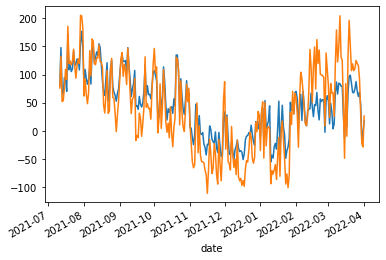

In [36]:
plt.figure()

plt.plot(X_test.index, pred)
y_test_stationary.plot()

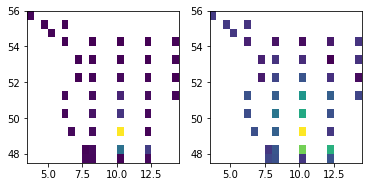

In [37]:
# get feature impotance from regressor
feature_importance = solar_regressor.get_booster().get_score(importance_type='total_gain')

# make a data frame with feature importances
feature_importance = pd.DataFrame.from_dict(feature_importance, orient='index', columns=["total_gain"]).sort_values(by = "total_gain", ascending=False)

# make a subset containing only "allsky..." feature importances
feature_importance_allsky = [row for row in feature_importance.index if 'ALLSKY_SFC_SW_DWN' in row]
feature_importance_allsky = feature_importance.loc[feature_importance.index.intersection(feature_importance_allsky)]

# put latitude, longitude and importance into a dataframe
feature_importance_allsky_map = [[row[0].split()[1], row[0].split()[2], row[1]['total_gain']] for row in feature_importance_allsky.iterrows()]
feature_importance_allsky_map = pd.DataFrame(feature_importance_allsky_map, columns = ['LAT', 'LON', 'importance'], dtype=float)


res = 0.5
LAT_map, LON_map = np.meshgrid(np.arange(feature_importance_allsky_map.LAT.min(), feature_importance_allsky_map.LAT.max()+res, res),
                               np.arange(feature_importance_allsky_map.LON.min(), feature_importance_allsky_map.LON.max()+res, res))

IMP_map = np.zeros(len(LAT_map.ravel()))

for i, (LAT, LON) in enumerate(zip(LAT_map.ravel(), LON_map.ravel())):
    df = feature_importance_allsky_map[(feature_importance_allsky_map.LAT == LAT) & (feature_importance_allsky_map.LON == LON)]
    if df.empty:
        IMP_map[i] = np.nan
    else:
        IMP_map[i] = df.importance

IMP_map = IMP_map.reshape(LAT_map.shape)

fig, ax = plt.subplots(1,2)

ax[0].pcolormesh(LON_map, LAT_map, IMP_map)

ratio = 1.0
x_left, x_right = ax[0].get_xlim()
y_low, y_high = ax[0].get_ylim()
ax[0].set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

ax[1].pcolormesh(LON_map, LAT_map, np.log(IMP_map))
x_left, x_right = ax[1].get_xlim()
y_low, y_high = ax[1].get_ylim()
ax[1].set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

In [44]:
# Create a base map
f_map = folium.Map(location=[51,10], tiles='cartodbpositron', zoom_start=5)

# Add a heatmap to the base map
HeatMap(data=feature_importance_allsky_map).add_to(f_map)
f_map

In [39]:
# Create a base map
f_map = folium.Map(location=[51,10], tiles='cartodbpositron', zoom_start=5)

feature_importance_allsky_map_log = feature_importance_allsky_map.copy()
feature_importance_allsky_map_log.importance = np.log(feature_importance_allsky_map.importance)

# Add a heatmap to the base map
HeatMap(data=feature_importance_allsky_map_log).add_to(f_map)
f_map

In [13]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(solar_regressor, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

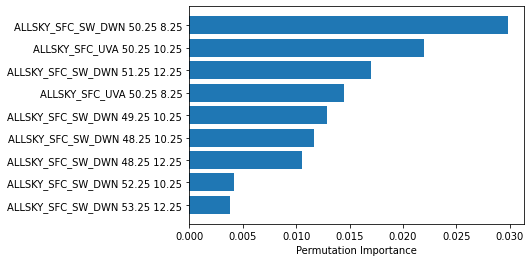

In [125]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(weather_electricity_raw.columns[sorted_idx[-10:-1]], perm_importance.importances_mean[sorted_idx[-10:-1]])
plt.xlabel("Permutation Importance")

In [126]:
#allsky_sfc_sw_dwn = [col for col in weather_electricity_raw.columns if 'ALLSKY_SFC_SW_DWN' in col]

# make a data frame with permutated feature importances
keys = weather_electricity_raw.columns[sorted_idx]
values = perm_importance['importances_mean'][sorted_idx]
feature_importance_per = pd.DataFrame(data=values, index=keys, columns=["importances_mean"]).sort_values(by = "importances_mean", ascending=False)

# make a subset containing only "allsky..." feature importances
feature_importance_per_allsky = [row for row in feature_importance_per.index if 'ALLSKY_SFC_SW_DWN' in row]
feature_importance_per_allsky = feature_importance_per.loc[feature_importance_per.index.intersection(feature_importance_per_allsky)]

# put latitude, longitude and importance into a dataframe
feature_importance_per_allsky_map = [[row[0].split()[1], row[0].split()[2], row[1]['importances_mean']] for row in feature_importance_per_allsky.iterrows()]
feature_importance_per_allsky_map = pd.DataFrame(feature_importance_per_allsky_map, columns = ['LAT', 'LON', 'importances_mean'], dtype=float)


# Create a base map
f_map = folium.Map(location=[51,10], tiles='cartodbpositron', zoom_start=5)

# Add a heatmap to the base map
HeatMap(data=feature_importance_per_allsky_map).add_to(f_map)
f_map

/tmp/ipykernel_55615/4004141163.py:27: RuntimeWarning: invalid value encountered in sqrt
  ax[1].pcolormesh(LON_map, LAT_map, np.sqrt(IMP_map))


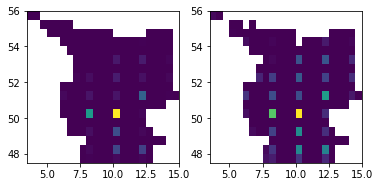

In [175]:
res = 0.5
LAT_map, LON_map = np.meshgrid(np.arange(feature_importance_per_allsky_map.LAT.min(), feature_importance_per_allsky_map.LAT.max()+res, res),
                               np.arange(feature_importance_per_allsky_map.LON.min(), feature_importance_per_allsky_map.LON.max()+res, res))

IMP_map = np.zeros(len(LAT_map.ravel()))

tst=0
for i, (LAT, LON) in enumerate(zip(LAT_map.ravel(), LON_map.ravel())):
    df = feature_importance_per_allsky_map[(feature_importance_per_allsky_map.LAT == LAT) & (feature_importance_per_allsky_map.LON == LON)]
    if df.empty:
        IMP_map[i] = np.nan
    else:
        IMP_map[i] = df.importances_mean
        tst+=1

IMP_map = IMP_map.reshape(LAT_map.shape)

fig, ax = plt.subplots(1,2)

ax[0].pcolormesh(LON_map, LAT_map, IMP_map)
ratio = 1.0
x_left, x_right = ax[0].get_xlim()
y_low, y_high = ax[0].get_ylim()
ax[0].set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

#with np.errstate(invalid='ignore'):
ax[1].pcolormesh(LON_map, LAT_map, np.sqrt(IMP_map))
x_left, x_right = ax[1].get_xlim()
y_low, y_high = ax[1].get_ylim()
ax[1].set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# ML with XGBoost, learn the solar data

## Establish a baseline model

In [57]:
ws50m_columns = [col for col in weather_electricity.columns if 'WS50M' in col]

# Select subset of predictors and the target
X = weather_electricity[ws50m_columns].copy()
y = weather_electricity.Wind

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, train_size=0.9)

wind_regressor = xgb.XGBRegressor(n_estimators=500, early_stopping_rounds=5, learning_rate=0.1)
wind_regressor.fit(X_train, y_train, 
                   eval_set=[(X_test, y_test)],
                   verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=5, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [58]:
# Predict using the model
y_predicted = wind_regressor.predict(X_test)

# RMSE Computation
rmse = np.sqrt(MSE(y_test, y_predicted))
print("RMSE : % .2f" %(rmse))
print("Average of y : % .2f" %(y.mean()))

RMSE :  52.53
Average of y :  257.86


## With stationary data

In [78]:
data = data_conditioning(X_train, X_test, y_train, y_test)
y_train_stationary, y_test_stationary = data.y_train_stationary, data.y_test_stationary

wind_stationary_regressor = xgb.XGBRegressor(n_estimators=500, early_stopping_rounds=5, learning_rate=0.1)
wind_stationary_regressor.fit(X_train, y_train_stationary, 
                               eval_set=[(X_test, y_test_stationary)],
                               verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=5, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [79]:
# Predict using the model

y_stationary_predicted = wind_stationary_regressor.predict(X_test)
y_predicted = data.reverse_stationary(y_stationary_predicted)

# RMSE Computation
rmse = np.sqrt(MSE(y_test, y_predicted))
print("RMSE : % .2f" %(rmse))
print("Average of y : % .2f" %(pd.concat([y_train_stationary, y_test_stationary]).mean()))

RMSE :  49.37
Average of y :  195.59


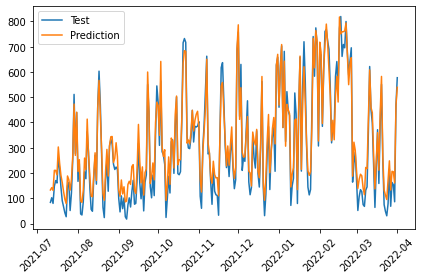

In [80]:
plt.figure()

plt.plot(y_test, label='Test')
plt.plot(X_test.index, y_predicted, label='Prediction')

plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()

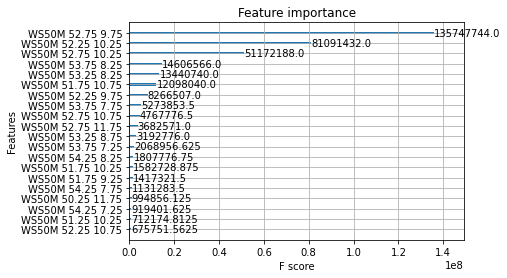

<Figure size 1152x864 with 0 Axes>

In [81]:
ax = xgb.plot_importance(wind_stationary_regressor, max_num_features=20, importance_type='total_gain')
#ax.set_xscale('log')
plt.figure(figsize = (16, 12))
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


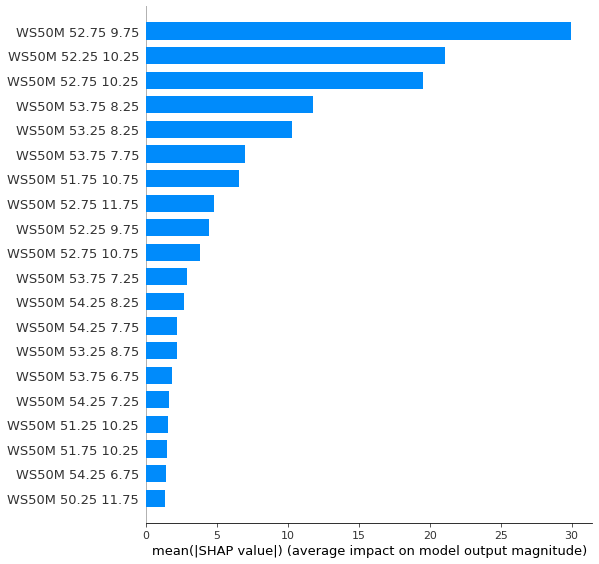

In [83]:
import shap

shap_values = shap.TreeExplainer(wind_stationary_regressor).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [92]:
np.shape(shap_values)

(2383, 2442)

In [93]:
np.shape(X_train)

(2383, 2442)

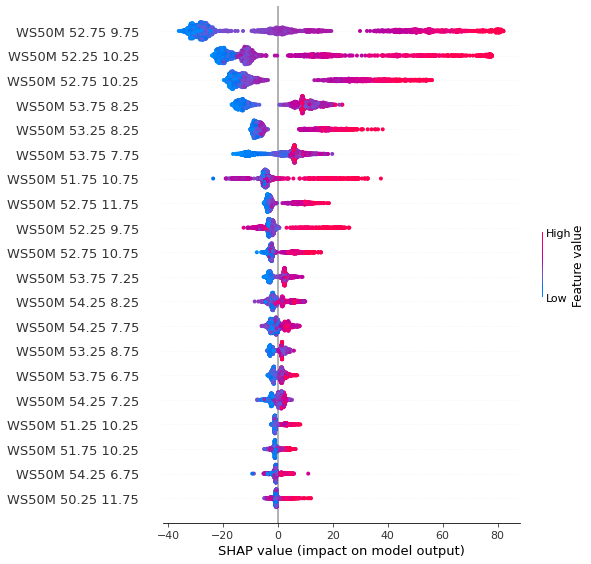

In [89]:
shap.summary_plot(shap_values, X_train)

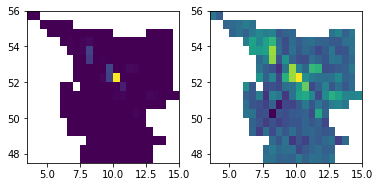

In [64]:
# get feature impotance from regressor
feature_importance = wind_regressor.get_booster().get_score(importance_type='total_gain')

# make a data frame with feature importances
feature_importance = pd.DataFrame.from_dict(feature_importance, orient='index', columns=["total_gain"]).sort_values(by = "total_gain", ascending=False)

# make a subset containing only "ws50m..." feature importances
feature_importance_ws50m = [row for row in feature_importance.index if 'WS50M' in row]
feature_importance_ws50m = feature_importance.loc[feature_importance.index.intersection(feature_importance_ws50m)]

# put latitude, longitude and importance into a dataframe
feature_importance_ws50m_map = [[row[0].split()[1], row[0].split()[2], row[1]['total_gain']] for row in feature_importance_ws50m.iterrows()]
feature_importance_ws50m_map = pd.DataFrame(feature_importance_ws50m_map, columns = ['LAT', 'LON', 'importance'], dtype=float)


res = 0.5
LAT_map, LON_map = np.meshgrid(np.arange(feature_importance_ws50m_map.LAT.min(), feature_importance_ws50m_map.LAT.max()+res, res),
                               np.arange(feature_importance_ws50m_map.LON.min(), feature_importance_ws50m_map.LON.max()+res, res))

IMP_map = np.zeros(len(LAT_map.ravel()))

for i, (LAT, LON) in enumerate(zip(LAT_map.ravel(), LON_map.ravel())):
    df = feature_importance_ws50m_map[(feature_importance_ws50m_map.LAT == LAT) & (feature_importance_ws50m_map.LON == LON)]
    if df.empty:
        IMP_map[i] = np.nan
    else:
        IMP_map[i] = df.importance

IMP_map = IMP_map.reshape(LAT_map.shape)

fig, ax = plt.subplots(1,2)

ax[0].pcolormesh(LON_map, LAT_map, IMP_map)

ratio = 1.0
x_left, x_right = ax[0].get_xlim()
y_low, y_high = ax[0].get_ylim()
ax[0].set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

ax[1].pcolormesh(LON_map, LAT_map, np.log(IMP_map))
x_left, x_right = ax[1].get_xlim()
y_low, y_high = ax[1].get_ylim()
ax[1].set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

## With all available data inculded

In [69]:
X = weather_electricity.iloc[:,:-2]
y = weather_electricity.Wind
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, train_size=0.9)

data = data_conditioning(X_train, X_test, y_train, y_test)
y_train_stationary, y_test_stationary = data.y_train_stationary, data.y_test_stationary

wind_stationary_regressor = xgb.XGBRegressor(n_estimators=500, early_stopping_rounds=5, learning_rate=0.1)
wind_stationary_regressor.fit(X_train, y_train_stationary, 
                              eval_set=[(X_test, y_test_stationary)],
                              verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=5, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [71]:
# Predict using the model
y_stationary_predicted = wind_stationary_regressor.predict(X_test)
y_predicted = data.reverse_stationary(y_stationary_predicted)

# RMSE Computation
rmse = np.sqrt(MSE(y_test, y_predicted))
print("RMSE : % .2f" %(rmse))
print("Average of y : % .2f" %(pd.concat([y_train_stationary, y_test_stationary]).mean()))

RMSE :  49.37
Average of y :  195.59


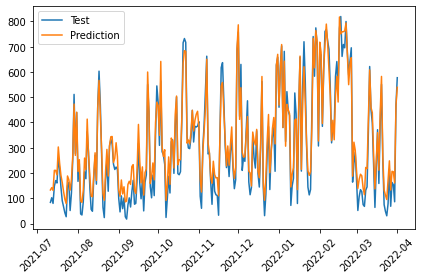

In [72]:
plt.figure()

plt.plot(y_test, label='Test')
plt.plot(X_test.index, y_predicted, label='Prediction')

plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()

In [ ]:
from sklearn.metrics import mean_squared_error
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
       'gamma': hp.uniform ('gamma', 1,9),
       'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
       'reg_lambda' : hp.uniform('reg_lambda', 0,1),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
       'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
       'n_estimators': 180,
       'seed': 0
      }

def objective(space):
    clf=xgb.XGBRegressor(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']), early_stopping_rounds=10, eval_metric="rmse")
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation,
            verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = mean_squared_error(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)